# Example: Vertical instability (growth rate) calculations

---

This notebook will demonstrate various different ways to calculate the **growth rates** (or **timescales**) associated with **vertically unstable modes** of an equilibrium. 

---



---

### The deformable growth rate model

Assume we have solved the Grad-Shafranov equation and have obtained an equilibrium. From this we can extract the plasma current density discretised over the spatial domain (these are only non-zero inside the LCFS so we mask points outside of the limiter to save memory):

\begin{equation*}
    \bold{I}_y := \bold{I}_y^{GS} (\bold{I}_m, I_p, \bold{\theta}).
    \tag{1}
\end{equation*}

This is a function of the: 
- currents in the metal conductors $\bold{I}_m$ (i.e. the active coils and passive structures).
- plasma current $I_p$.
- free parameters $\bold{\theta}$ used to define the plasma current density profiles (i.e. $J_p(\psi,R,Z)$). 

We then wish to linearise the following circuit and plasma current equations in order to estimate the instability timescales/growth rates of the plasma. 

**Circuit equations**: (governing the flow of current in the active coils and passive structures)

\begin{equation}
    M_{m,m} \bold{\dot{I}}_m + M_{m,y} \bold{\dot{I}}_y + R_{m,m} \bold{I}_m = \bold{V}_m
    \tag{2}
\end{equation}

Here:
- $M_{m,m}$ is the symmetric matrix of mutual inductances between all of the metals. 
- $M_{m,y}$ is the matrix of mutual inductances between all of the metals and the discretised plasma current density. 
- $R_{m,m}$ is the diagonal matrix of resistances in the metals.
- $V_m$ is the vector of voltages applied to the metals (note: these are non-zero for the active coils only).
- Note that the dots indicate time derivatives. 

**Plasma equations**: (governing the flow of current in the plasma)

\begin{equation}
    \frac{\bold{I}_y}{I_p} \left( M_{y,y} \bold{\dot{I}}_y + M_{y,m} \bold{\dot{I}}_m + R_{y,y} \bold{I}_y \right) = \bold{0}
    \tag{3}
\end{equation}

Here:
- $M_{y,m} = M_{m,y}^{T}$ (from above).
- $R_{y,y} = 2 \pi \sigma_p R /dA$ is the diagonal matrix of resistances for each plasma element.
    - $\sigma_p$ is the assigned plasma resistivity. 
    - $R$ is a matrix storing the radial position of each plasma element.
    - $dA$ is the area of each plasma element.


**Linearisation of discretised plasma current density**:

To simplify these equations, we linearise equation (1) around the current GS equilibrium such that:

\begin{equation}
    \dot{\bold{I}_y} \approx \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \dot{\bold{I}_m} + \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I_p} + \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}}.
    \tag{4}
\end{equation}

These Jacobians are calculated in FreeGSNKE using finite differences. The use of these Jacobians is what makes this a **deformable** growth rate model. 

Assuming here that the profile parameters $\bold{\theta}$ remain constant in time, we can plug this equation into both (2) and (3) and re-arrange:

\begin{align}
    \left( M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \right) \bold{\dot{I}}_m + M_{m,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I_p} + R_{m,m} \bold{I}_m = \bold{V}_m \tag{5} \\
    \frac{\bold{I}_y}{I_p} \left[ \left( M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} + M_{y,m} \right) \dot{\bold{I}}_m  + M_{y,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I_p} + R_{y,y} \bold{I}_y \right] = \bold{0}. \tag{6}
\end{align}

To write this in state matrix form, we need to remove the dependence of equation (6) on the denominator of $I_p$ by introducing two terms:
- $\hat{\bold{I}}_y = \bold{I}_y / I_p$ is the scaled discretised plasma current density over the spatial domain.
- $R_p = \hat{\bold{I}}_y^{T} R_{y,y} \hat{\bold{I}}_y$ is the "lumped" plasma resistance.

This results in the state matrix system $M \dot{\bold{x}} + R \bold{x} = \bold{c}$:

\begin{equation}
\begin{aligned}
\left[\begin{array}{cc}
 M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} & M_{m,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \\ 
\frac{\hat{\bold{I}}_y}{R_p} \left( M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} + M_{y,m} \right) & \frac{\hat{\bold{I}}_y}{R_p} M_{y,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS}
\end{array}\right]
\left[\begin{array}{c}
\dot{\bold{I}}_m \\ 
\dot{I}_p
\end{array}\right] +

\left[\begin{array}{cc}
R_{m,m} & 0 \\ 
0 & R_p
\end{array}\right]
\left[\begin{array}{c}
\bold{I}_m \\ 
I_p
\end{array}\right]

&=
\left[\begin{array}{c}
\bold{V}_m \\ 
0 
\end{array}\right].

\end{aligned}
\end{equation}

Re-arranging, we can write this as 

$$\dot{\bold{x}} = A\bold{x} + \bold{b}, $$

where $A = -M^{-1}R$ and $\bold{b} = M^{-1}\bold{c}$. 

---

In [17]:
evals = nonlinear_solver.linearised_sol.all_timescales_const_Ip
idx = np.where(evals > 0)[0][0]
xu = nonlinear_solver.linearised_sol.all_modes_const_Ip[idx,:]

L = nonlinear_solver.linearised_sol.M0matrix
S = -nonlinear_solver.linearised_sol.dMmatrix

((xu.T @ S @ xu)/(xu.T @ L @ xu)) - 1

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 35 is different from 34)

In [18]:
xu.shape

(34,)

In [15]:
idx

13

### What are growth rates, how do we obtain them, and why are they useful?

The eigenvalues of $A$, denoted as $\gamma_i$ represent the **growth (or decay) rates** of eigenvectors $\bold{v}_i$ of the system (which themselves are reffered to as **modes**, representing mode currents in the metals and the total plasma).

Therefore:
- $\gamma_i > 0$ corresponds to an **unstable** mode $\bold{v}_i$.
- $\gamma_i < 0$ corresponds to an **stable** mode $\bold{v}_i$.

Typically a plasma should (always) have at least one unstable mode. If all modes are stable, then it does not strictly mean that the plasma is stable but may instead be **Alfven** unstable -- which means what?

Often it is preferred to work with the **instability timescale**. These can be found by simply taking the reciprocal of the growth rates. 





### Quick example: (with things to plot)

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.
Forward static solve SUCCESS. Tolerance 8.29e-10 (vs. requested 1.00e-09) reached in 26/100 iterations.


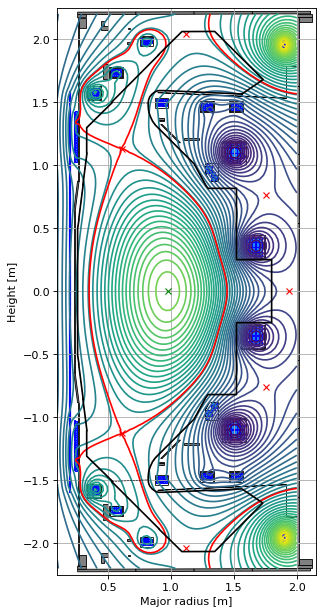

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"../machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Solving the linearised system requires inititialising the nonlinear solver object. Here the matrices are formed (requiring Jacobian calculations and therefore lots of forward GS solver) and the eigenvalues and vectors are found.

The larger the number of metals (modes) you include, the more computationally heavy this call becomes. Here we will calculate using all available metal modes, however, later on we can show how to exclude those with specific frequencies, timescales, coupling, etc to increase speed. 

In [2]:
from freegsnke import nonlinear_solve

nonlinear_solver = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    plasma_resistivity=1e-6, # this needs to be set (alternatively you can calculate the growth rates without the plasma model)
    min_dIy_dI=1e-10,        # this has been set artificially low in this example
    max_mode_frequency=1e1, # this has been set artificially high in this example
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 8.29e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'threshold_dIy_dI', 'min_dIy_dI', and 'max_mode_frequency' option selected --> passive structure modes are selected according to these thresholds.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      0 selected with characteristic timescales larger than 'max_mode_frequency'
      22 selected that couple with the plasma more than 'threshold_dIy_dI', despite having fast timescales
      0 selected that couple with the plasma less than 'min_dIy_dI', despite having slow timescales
      total selected = 22 (out of 138)
   Total number of modes = 34 (12 active coils + 22 passive structures)
      (Note: some additional modes may be removed after Jacobian c

Notice the growth rates, instability margin, and stability margin have imaginary components. These should always be zero or negligible. 

Basic stuff:

In [3]:
# accessing the number of modes
nonlinear_solver.n_metal_modes   # total (actives + passives)
nonlinear_solver.n_active_coils  # actives
nonlinear_solver.n_passive_coils # passives

138

In [4]:
# accessing the modes
timescales = nonlinear_solver.linearised_sol.all_timescales # all eigenvalues: timescales (descending order)
growth_rates = 1/timescales                                 # growth rates are simply 1/timescales (descending order)
modes = nonlinear_solver.linearised_sol.all_modes           # all eigenvectors (columns in same order as e'values)

# extracting the unstable mode(s)
mask = (timescales > 0)
unstable_timescales = timescales[mask]
unstable_modes = np.squeeze(modes[:,mask])

Visualising the poloidal flux produced by the eigenvectors:

Mode 14 ---> unstable
Growth rate = 9.18e+01 [1/s]
Timescale = 1.09e-02 [s]


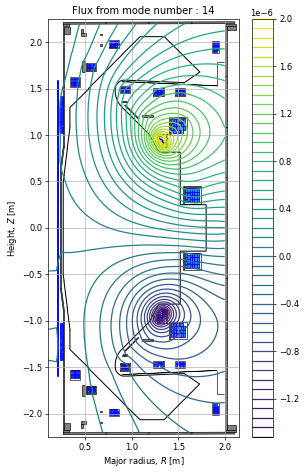

In [73]:
# Greens matrices for the modes (useful when plotting later)
nonlinear_solver.vessel_modes_greens.shape 

# mode number (choose which one you want to visualise)
i = 14
mode_currents = np.real(modes[:,i])

# the associated instability timescale and growth rate
print(f"Mode {i} ---> {'stable' if np.real(timescales[i]) < 0 else 'unstable'}")
print(f"Growth rate = {np.real(growth_rates[i]):.2e} [1/s]")
print(f"Timescale = {np.real(timescales[i]):.2e} [s]")

# multiply each metal current with its corresponding Greens matrix and sum
# don't forget to omit the plasma current mode
flux = np.sum(mode_currents[0:-1, np.newaxis, np.newaxis] * nonlinear_solver.vessel_modes_greens, axis=0)


# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Flux from mode number : {i}")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contour(eq.R, eq.Z, flux, levels=50)                        
cbar = plt.colorbar(im, ax=ax, fraction=0.09)

Here we extract two different plasma current density $J_{p}(R,Z)$ maps: call them $J_{p}^{deform}$ and $J_{p}^{rigid}$.

The first corresponds to an application of the unstable mode currents to the equilbirium, solving the GS equation again, and observing the "deformable" movement of the plasma core (it shifts in (R,Z) and also it's boundary will displace). This results in a new current density map $J_{p}^{deform}$. 

The second corresponds to taking the (R,Z) shifts in the current centres (from $J_{p}^{deform}$) and shifting the $J_p$ map from the orginal equilibrium. In this case we observe a "rigid" displacement of the plasma current density: $J_{p}^{rigid}$. 

While they do not siginficantly different in the case presented here, they will when studying more elongated vertically unstable plasmas.

Rate of change of Rcurrent wrt unstable mode = 8.24e-06 [m].
Rate of change of Zcurrent wrt unstable mode = 2.53e-05 [m].


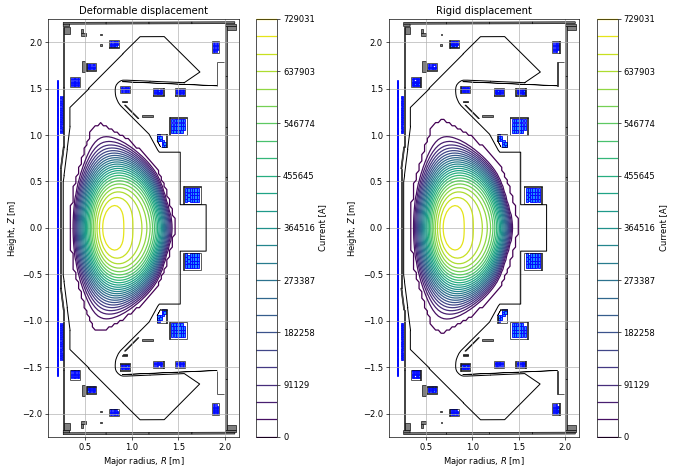

In [109]:
# data
jtor_maps = nonlinear_solver.deformable_vs_rigid_jtor  

# rate of change of R and Z current centre of plasma wrt to the unstable mode only
dRZd_unstable_mode = nonlinear_solver.dRZd_unstable_mode
print(f"Rate of change of Rcurrent wrt unstable mode = {dRZd_unstable_mode[0]:.2e} [m].")
print(f"Rate of change of Zcurrent wrt unstable mode = {dRZd_unstable_mode[1]:.2e} [m].")

# plot

min_lev = min(np.min(jtor_maps[0]),np.min(jtor_maps[1]))
max_lev = max(np.max(jtor_maps[0]),np.max(jtor_maps[1]))
levels = np.linspace(min_lev, max_lev, 25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=60)

ax1.grid(True, which='both')
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(f"Deformable displacement")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax1,show=False)
ax1.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, jtor_maps[0], levels=levels)                        
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)
cbar.set_label('Current [A]')


ax2.grid(True, which='both')
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(f"Rigid displacement")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')

eq.tokamak.plot(axis=ax2,show=False)
ax2.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, jtor_maps[1], levels=levels)                        
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)
cbar.set_label('Current [A]')


Here we demonstrate how to visualise the derivative of the plasma current density with respect to the metal currents (via the Jacobian). 

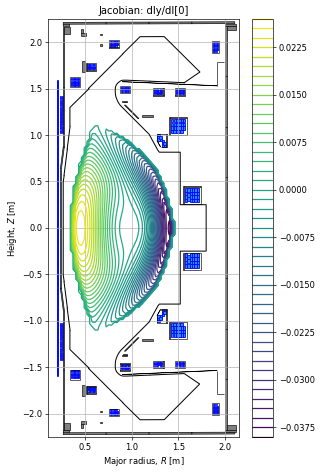

In [83]:
# extract the Jacobian (no. plasma current points x no. modes) 
# i.e. the full finite-difference Jacobian of plasma current density points wrt metal currents 
dIydI = nonlinear_solver.dIydI       

# choose the mode number you want to plot
i = 0

# extracts the column of the Jacobian 
derivs = np.full(nonlinear_solver.limiter_handler.mask_inside_limiter.shape, np.nan)
derivs[nonlinear_solver.limiter_handler.mask_inside_limiter] = dIydI[:,i]

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Jacobian: dIy/dI[{i}]")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contour(eq.R, eq.Z, derivs, levels=50)                        
cbar = plt.colorbar(im, ax=ax, fraction=0.09)


In [78]:
nonlinear_solver.linearised_sol.n_independent_vars

150

### Rigid plasma stability metrics

Here we'll outline how a few commonly used stability metrics (assuming a rigid, non-deformable plasma) are calculated in FreeGSNKE.

#### Leuer parameter

Here, we describe the stability parameter outlined in equation (6) of [Leuer (1989)](https://www.tandfonline.com/doi/abs/10.13182/FST89-A39747). See the reference for more details on its interpretation. 

Using notation from above, the (generalised) stability parameter for the system is defined as the ratio of stabilising force gradient to de-stabilising force gradient acting on the system:

\begin{equation}
    f := \frac{f_{stab}}{f_{destab}} = \frac{\bold{I}_y^T M'_{y,m} M^{-1}_{m,m} M'_{m,y} \bold{I}_y}{\bold{I}_y^T M''_{y,m} \bold{I}_m},
\end{equation}

where $M'$ denotes the derivative (and second derivative $M''$) of the mutual inductances with respect to $Z$. We can find these derivatives using the relations:

\begin{align}
    \frac{d}{dZ} M_{y,m} = \frac{d}{dZ} M (R_y, Z_y ; R_m, Z_m) &= \frac{d}{dZ} 2 \pi G (R_y, Z_y ; R_m, Z_m) \\
    &= \frac{d}{dZ} 2 \pi \psi (R_y, Z_y ; R_m, Z_m) \\
    &= - 2 \pi R_m B_R (R_y, Z_y ; R_m, Z_m). 
\end{align}

Here, $G$ is the Greens function between the plasma locations and the metal locations (which is equal to the poloidal flux $\psi_{y,m}$ at the metal locations produced by a unit current at the plasma locations). We can then use the relation $B_R = - (d \psi / dZ) / R$, where $B_R$ is the radial magnetic field. Note the actual calculation of this is slightly more involed when the metals are defined using filaments (see source code in nonlinear_solve.py).

The second derivative is the same except we need $d B_R/ dZ$ instead of $B_R$. 

Different combinations of stability parameter can be calculated by choosing which metals ($m$) to include. You can do the following for example (note these are similar because there are no passive currents in this particular equilibrium!):

In [6]:
print(fr"Ratio of passive metals stabilisation to active metals de-stabilisation = {nonlinear_solver.passives_stab_force/nonlinear_solver.actives_destab_force}")
print(f"Ratio of all metals stabilisation to active coil de-stabilisation = {nonlinear_solver.all_coils_stab_force/nonlinear_solver.actives_destab_force}")
print(f"Ratio of all metals stabilisation to all metals de-stabilisation = {nonlinear_solver.all_coils_stab_force/nonlinear_solver.all_coils_destab_force}")

Ratio of passive metals stabilisation to active metals de-stabilisation = 1.8402250074574238
Ratio of all metals stabilisation to active coil de-stabilisation = 1.8402398740697117
Ratio of all metals stabilisation to all metals de-stabilisation = 1.8402398740697117


#### Portone parameter

[Portone (2005)](https://iopscience.iop.org/article/10.1088/0029-5515/45/8/021)


Section on the Portone stability margin calculation, what it is, and what it means:

The (inductive) stability margins are found by solving for the eigenvalues of:

$$ A := - M_{m,m}^{-1} M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} - \bold{I}, $$

where $\bold{I}$ is the identity matrix. We say "inductive" because no resistance terms are present in this metric.

The positive eigenvalue corresponds to the unstable inductive stability margin. 

It measures what?

In [74]:
# section on the stability margin
# nonlinear_solver.linearised_sol.all_stability_margins # all calculated stability margins 

Explain that if you don't know th eplasma resistivity or don't want to include the contribution from the plasma, you can omit the equation from the linearisation above. To access the timescales and modes simply do the following and then carry out your analysis as desired. 

In [76]:
# Note that if you don't have an accurate characterisation of the plasma resistivity, you can also solve the same system without the contribution from the plasma current $I_p$ (assuming $\dot{I}_p \approx 0).

# simply call:

1/nonlinear_solver.linearised_sol.all_timescales_const_Ip # all eigenvalues: growth rates (descending order) without plasma equation
nonlinear_solver.linearised_sol.all_timescales_const_Ip # all eigenvalues: timescales (descending order) without plasma equation
nonlinear_solver.linearised_sol.all_modes_const_Ip      # all eigenvectors (columns in same order as e'values) without plasma equation


array([[-1.27348998e-03,  1.59580076e-02,  1.48456736e-01, ...,
        -3.66437659e-05, -2.54063548e-05, -9.36294528e-06],
       [-1.68532928e-02,  2.68755797e-02,  2.25914793e-01, ...,
         4.58579076e-04,  2.52626452e-04,  1.50086138e-04],
       [-1.94756291e-02,  3.61613456e-02,  3.13426086e-01, ...,
         2.11279639e-04, -2.46807560e-03, -3.48245657e-03],
       ...,
       [ 1.91214249e-04, -5.78168060e-05, -9.15668005e-05, ...,
        -3.27653544e-04,  1.70141430e-05, -2.11290417e-04],
       [ 1.48139247e-04, -4.30006587e-05, -8.43185225e-05, ...,
        -5.69279542e-04, -9.40646122e-05, -1.45436619e-04],
       [ 7.57906051e-04, -9.62264069e-04, -2.24789628e-03, ...,
         2.82327235e-04,  5.28236149e-04, -1.50321637e-03]])

### Different ways of calculating based on mode decomposition:

Note that this was quite slow.

While this all holds when calculating using all the metals, we can do passive mode decompo/sition (see below), which reduced the number of equations and computaitonal compelxit yof the problem. 

The generic method of performing the mode decomposition is outlined in the [Amorisco et al. (2024)](https://pubs.aip.org/aip/pop/article/31/4/042517/3286904/FreeGSNKE-A-Python-based-dynamic-free-boundary). 

There do however exist different methods for carrying out this decomposition and choosing which modes will remain. 


Check out other options in the `nl_solver` object too. For example, if you have alternative resistances and inductances for the metals, they can also be set manually. I 


#### Fixing the number of passive structure modes explicity

The active coils will always be included as modes but you can set the number of passive structure modes directly. 

The way this decomposition works is that:

A first estimate of $\|  \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \|$ is calculated for all possible modes (actives + passive strucutres) without fully solving GS equation for each. This is done by perturbing the currents in the modes (active and passive coils), updating the poloidal flux produced by these currents, and then evaluating the plasma current density $J_p(R,Z, \psi$)$ (where $\psi$ is the flux from the plasma and the modes combined). 

We can then order each modes by the size of its $\|  \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \|$, from highest (strongest coupling) to lowest (weakest coupling). 

As we increase `fix_n_vessel_modes`, then modes with a stronger and stronger coupling are added to the decomposition. As more modes are added, the timescale of the unstable mode is expected to increase (growth rate decreases), though not strictly monotonically.

In [2]:
from freegsnke import nonlinear_solve

nonlinear_solver_fixed_modes = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    plasma_resistivity=1e-6, # this needs to be set
    fix_n_vessel_modes=50,
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 8.29e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'fix_n_vessel_modes' option selected --> passive structure modes that couple most to the strongest passive structure mode are being selected.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      50 selected using 'fix_n_vessel_modes'
   Total number of modes = 62 (12 active coils + 50 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation)
-----
Building the 3051 x 63 Jacobian (dIy/dI) of plasma current density (inside the LCFS) with respect to all metal currents and the total plasma current.
done.
-----
Linear growth calculations:
      Growth rate = [  108.27200377+0.j 12374.22730715+0.j] [1/s]
      Instabi

In [6]:
# extract the L and S matrices
n = nonlinear_solver.linearised_sol.n_independent_vars
L = nonlinear_solver.linearised_sol.M0matrix[0:n, 0:n]
S = -nonlinear_solver.linearised_sol.dMmatrix[0:n, 0:n]

# find e'values
A = np.linalg.solve(L, S) - np.eye(n)
np.sort(np.linalg.eigvals(A),)

# # extract stability margin
# mask = self.all_stability_margins > 0
# self.stability_margin = self.all_stability_margins[
#     mask
# ]  # the positive (i.e. unstable) eigenvalues

array([-3.07253966+0.00000000e+00j, -1.06612995+0.00000000e+00j,
       -1.04321671+0.00000000e+00j, -1.00760465+0.00000000e+00j,
       -1.00394774+0.00000000e+00j, -1.0004931 +0.00000000e+00j,
       -1.00020608+0.00000000e+00j, -1.00014592-1.52097652e-05j,
       -1.00014592+1.52097652e-05j, -1.00004318-5.64951917e-05j,
       -1.00004318+5.64951917e-05j, -1.0000111 -1.45546260e-06j,
       -1.0000111 +1.45546260e-06j, -1.00000007+0.00000000e+00j,
       -1.00000002-1.67031120e-08j, -1.00000002+1.67031120e-08j,
       -1.00000001-1.11976150e-07j, -1.00000001+1.11976150e-07j,
       -1.        -5.99860995e-09j, -1.        +5.99860995e-09j,
       -1.        +0.00000000e+00j, -1.        +0.00000000e+00j,
       -1.        -1.88832789e-11j, -1.        +1.88832789e-11j,
       -1.        -9.40988206e-11j, -1.        +9.40988206e-11j,
       -1.        +0.00000000e+00j, -0.99999953+0.00000000e+00j,
       -0.99999922+0.00000000e+00j, -0.99999638+0.00000000e+00j,
       -0.9999931 +0.0000

In [11]:
# extract the L and S matrices
n = nonlinear_solver.linearised_sol.n_independent_vars
L = nonlinear_solver.linearised_sol.M0matrix[0:n, 0:n]
Ls = nonlinear_solver.linearised_sol.dMmatrix[0:n, 0:n]

LL = L + Ls

# find e'values
A = -np.linalg.inv(L)*LL
np.sort(np.linalg.eigvals(A))

# # extract stability margin
# mask = self.all_stability_margins > 0
# self.stability_margin = self.all_stability_margins[
#     mask
# ]  # the positive (i.e. unstable) eigenvalues

array([-15.7508777 +0.j        ,  -7.99689675+0.j        ,
        -3.82804543+0.j        ,  -3.18721598-0.13217084j,
        -3.18721598+0.13217084j,  -2.61525232-0.02648936j,
        -2.61525232+0.02648936j,  -2.44574333-0.72531547j,
        -2.44574333+0.72531547j,  -2.42292938+0.j        ,
        -2.06195612+0.j        ,  -1.78628677-0.09075772j,
        -1.78628677+0.09075772j,  -1.60973304+0.j        ,
        -1.19828461+0.j        ,  -1.19634528+0.j        ,
        -1.09692249+0.j        ,  -1.04920761+0.j        ,
        -1.0284861 +0.j        ,  -0.93880413+0.j        ,
        -0.82806513-0.05758527j,  -0.82806513+0.05758527j,
        -0.73715903+0.j        ,  -0.68007798+0.j        ,
        -0.45947587+0.j        ,  -0.27210909+0.j        ,
        -0.16620843+0.j        ,   0.39815419+0.j        ,
         0.66410444+0.j        ,   0.96994547+0.j        ,
         2.10370303-0.05973831j,   2.10370303+0.05973831j,
         4.02555371+0.j        ,   7.25897562+0.j       

In [ ]:
grid=rzip_config.grid;
R=get(grid, 'R', 'data');
Rv=R(ones(size(rzip_config.index.vessel)), :);
Rc=R(ones(size(rzip_config.index.coilset)), :);
Rs = [Rc; Rv]; % OB: R co-ords large enough for the whole structure (vessel & coils)
# some sort of array of radii of the metals?


I = nonlinear_solver.Iy
Msp_prime = 2*np.pi*Rs.*rzip_config.br_struct_grid;
	 Mss = rzip_config.L_struct;

icoil = coil curerents

GridCoil_doubleprime=2*pi*Rc.*rzip_config.dbrdz_struct_grid(rzip_config.index.coilset, :);





stab = (I*Msp_prime') * (Mss \ (Msp_prime*I') ); %memory saving by Oliver.

destab = icoil*GridCoil_doubleprime*I';


fs = - stab / destab


Note that if a mode decomposition is carried out, then the eigenmodes that come out won't correspond to the coils order or the original machine and so they need to be converted back. 
This can be done with 

mode = 
nonlinear_solver_fixed_modes.evol_metal_curr.IdtoIvessel(Id=)


Analysis for me: looking into evolution of largest timescale over time (and why there might be two timescales). 

In [107]:
# run for lots of different values (takes a long time!)

n_vessel_modes = [0, 20, 40, 60, 80, 100, 120, 138]

timescales = []

for value in n_vessel_modes:

    nonlinear_solver_fixed_modes = nonlinear_solve.nl_solver(
        eq=eq, 
        profiles=profiles, 
        plasma_resistivity=1e-6, # this needs to be set (alternatively you can calculate the growth rates without the plasma model)
        min_dIy_dI=1e-10,        # this has been set artificially low in this example 
        max_mode_frequency=1e10, # this has been set artificially high in this example
        fix_n_vessel_modes=value,
    )

    timescales.append(nonlinear_solver_fixed_modes.linearised_sol.all_timescales)


-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 8.29e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'fix_n_vessel_modes' option selected --> passive structure modes that couple most to the strongest passive structure mode are being selected.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      0 selected using 'fix_n_vessel_modes'
   Total number of modes = 12 (12 active coils + 0 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation)
-----
Building the 3051 x 13 Jacobian (dIy/dI) of plasma current density (inside the LCFS) with respect to all metal currents and the total plasma current.
done.
-----
      No unstable modes found: either plasma stable, or more likely, it is Alfven unstable (i.e. needs more s

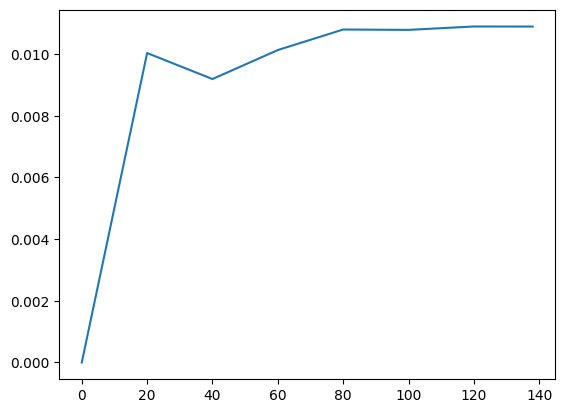

In [108]:
unstable_timescales = np.zeros(len(timescales))
for i, arr in enumerate(timescales):
    try:
        unstable_timescales[i] = max(np.real(arr[np.real(arr) > 0]))
    except:
        pass

plt.plot(n_vessel_modes, unstable_timescales)

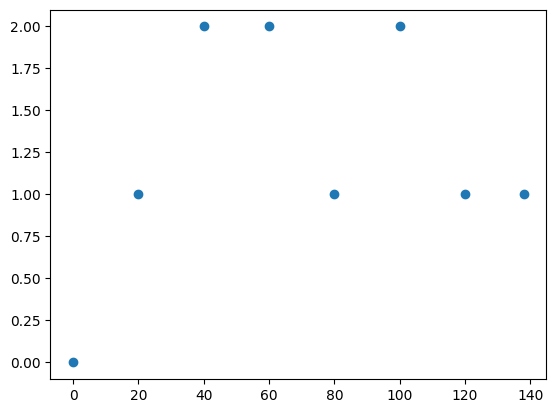

In [116]:
num_unstable_modes = np.zeros(len(timescales))
for i, arr in enumerate(timescales):
    try:
        num_unstable_modes[i] = len(arr[np.real(arr) > 0])
    except:
        pass

plt.scatter(n_vessel_modes, num_unstable_modes)

### More advanced study: moving coils/passives

In [ ]:
Could do this with one of the toy tokamak models from Nico's analysis. (see what else he had in there)

